In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
#import dice_ml
#from dice_ml.utils import helpers

In [ ]:
df = pd.read_csv('./student_depression_dataset.csv')
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [ ]:
meta_columns = ['id', 'Gender', 'Age', 'City', 'Profession']

In [ ]:
X = df.drop(columns=['Depression'])
y = df['Depression'].astype(int)
X = pd.get_dummies(X)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

X = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X), columns=X.columns)
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

In [ ]:
def train_model(model, param_grid, use_smote=False):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
    if use_smote:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    grid = GridSearchCV(model, param_grid, scoring='f1', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    print("Best Params:", grid.best_params_)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return grid.best_estimator_, X_train, X_test, y_train, y_test


In [ ]:
rf_model, X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_model(
    RandomForestClassifier(random_state=42),
    {'n_estimators': [100, 200], 'max_depth': [5, 10]}
)

lr_model, X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_model(
    LogisticRegression(solver='liblinear'),
    {'C': [0.1, 1.0, 10.0]}
)

rf_smote_model, X_train_rf_sm, X_test_rf_sm, y_train_rf_sm, y_test_rf_sm = train_model(
    RandomForestClassifier(random_state=42),
    {'n_estimators': [100, 200], 'max_depth': [5, 10]},
    use_smote=True
)

lr_smote_model, X_train_lr_sm, X_test_lr_sm, y_train_lr_sm, y_test_lr_sm = train_model(
    LogisticRegression(solver='liblinear'),
    {'C': [0.1, 1.0, 10.0]},
    use_smote=True
)


Best Params: {'max_depth': 10, 'n_estimators': 100}
[[1734  579]
 [ 377 2891]]
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      2313
           1       0.83      0.88      0.86      3268

    accuracy                           0.83      5581
   macro avg       0.83      0.82      0.82      5581
weighted avg       0.83      0.83      0.83      5581

Best Params: {'C': 1.0}
[[1838  475]
 [ 399 2869]]
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      2313
           1       0.86      0.88      0.87      3268

    accuracy                           0.84      5581
   macro avg       0.84      0.84      0.84      5581
weighted avg       0.84      0.84      0.84      5581

Best Params: {'max_depth': 10, 'n_estimators': 200}
[[1777  536]
 [ 422 2846]]
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      2313
           1       0.84     

                     Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
Model                                                                      
Random Forest          0.8287     0.8331  0.8846    0.8581   0.8172  0.8046
Logistic Regression    0.8434     0.8580  0.8779    0.8678   0.8363  0.8247
RF + SMOTE             0.8283     0.8415  0.8709    0.8559   0.8196  0.8085
LogReg + SMOTE         0.8421     0.8766  0.8501    0.8631   0.8405  0.8330


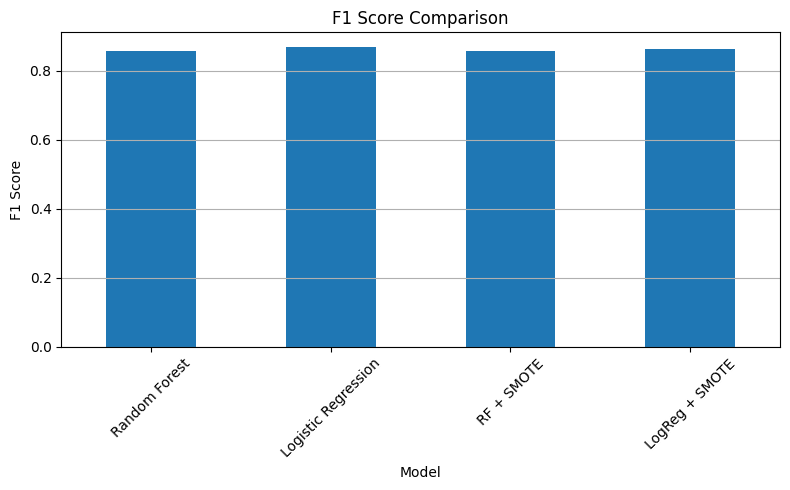

In [ ]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred),
        "PR AUC": average_precision_score(y_test, y_pred)
    }

results = [
    evaluate_model("Random Forest", rf_model, X_test_rf, y_test_rf),
    evaluate_model("Logistic Regression", lr_model, X_test_lr, y_test_lr),
    evaluate_model("RF + SMOTE", rf_smote_model, X_test_rf_sm, y_test_rf_sm),
    evaluate_model("LogReg + SMOTE", lr_smote_model, X_test_lr_sm, y_test_lr_sm)
]

results_df = pd.DataFrame(results).round(4).set_index("Model")
print(results_df)

# Plot
results_df[['F1 Score']].plot(kind='bar', legend=False, title='F1 Score Comparison', ylabel='F1 Score', figsize=(8, 5))
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

                                       Feature  Coefficient  AbsImportance
2                            Academic Pressure     1.171017       1.171017
114  Have you ever had suicidal thoughts ?_Yes     0.606938       0.606938
113   Have you ever had suicidal thoughts ?_No    -0.606938       0.606938
1                                          Age    -0.595385       0.595385
119                       Financial Stress_5.0     0.474639       0.474639
115                       Financial Stress_1.0    -0.444255       0.444255
7                             Work/Study Hours     0.438310       0.438310
5                           Study Satisfaction    -0.324592       0.324592
116                       Financial Stress_2.0    -0.273663       0.273663
84                    Dietary Habits_Unhealthy     0.259192       0.259192


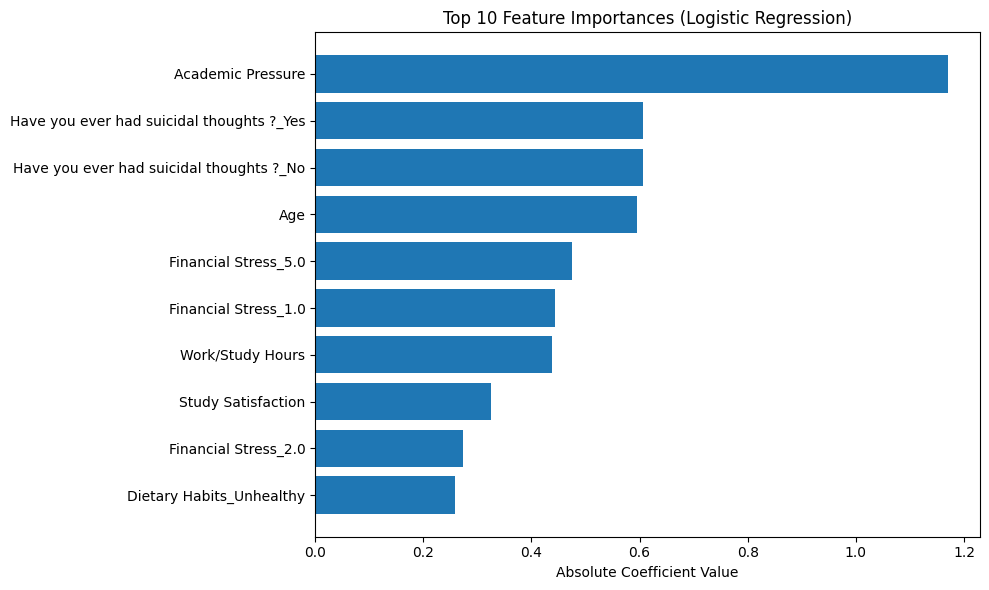

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Coefficient': lr_model.coef_[0],
    'AbsImportance': np.abs(lr_model.coef_[0])
}).sort_values(by='AbsImportance', ascending=False)


print(feature_importance.head(10))


plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10][::-1], feature_importance['AbsImportance'][:10][::-1])
plt.xlabel("Absolute Coefficient Value")
plt.title("Top 10 Feature Importances (Logistic Regression)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    lr_model,
    X_test_lr,     # must match what model was trained with
    y_test_lr,     # target for test set
    n_repeats=30,
    random_state=42
)

# Create DataFrame for interpretation
perm_df = pd.DataFrame({
    'Feature': X_test_lr.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)



In [ ]:
perm_df.head(10)

,Feature,Importance Mean,Importance Std
2,Academic Pressure,0.079376,0.004207
114,Have you ever had suicidal thoughts ?_Yes,0.025252,0.002595
113,Have you ever had suicidal thoughts ?_No,0.025252,0.002595
1,Age,0.016789,0.002228
119,Financial Stress_5.0,0.012035,0.002456
7,Work/Study Hours,0.010787,0.002761
115,Financial Stress_1.0,0.008762,0.001973
5,Study Satisfaction,0.005572,0.002130
81,Dietary Habits_Healthy,0.003148,0.001384
116,Financial Stress_2.0,0.003088,0.001069


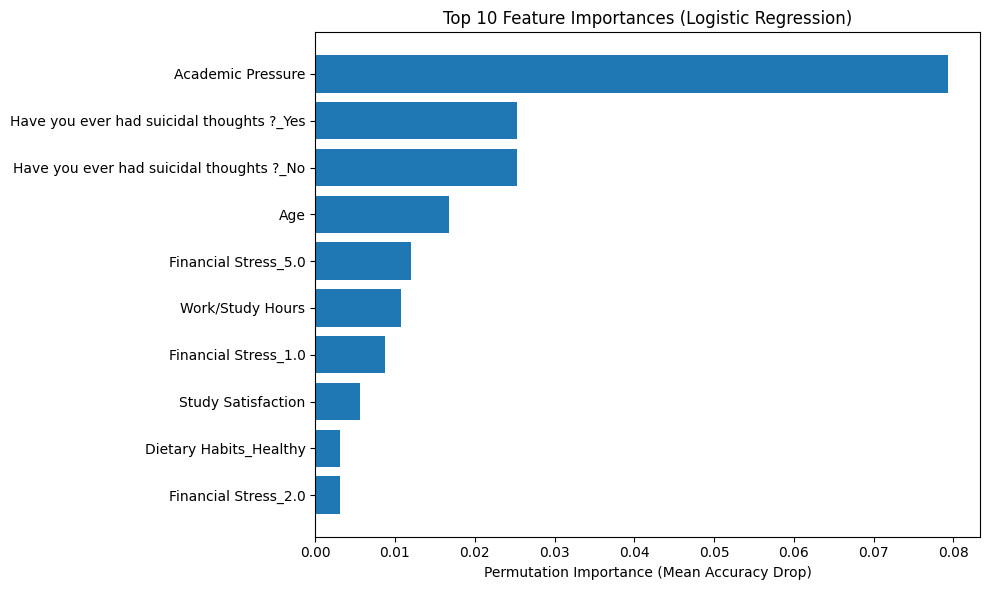

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(perm_df['Feature'][:10][::-1], perm_df['Importance Mean'][:10][::-1])
plt.xlabel("Permutation Importance (Mean Accuracy Drop)")
plt.title("Top 10 Feature Importances (Logistic Regression)")
plt.tight_layout()
plt.show()
